In [3]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import re

import shap


c:\BigData\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [108]:
# 데이터 로드
df = pd.read_excel(r"C:\BigData\PLmerged_resultFile0616_updated.xlsx")

In [109]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(numeric_cols)

Index(['Rk', 'Market Value', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s',
       'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG',
       'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1',
       'G+A.1', 'G-PK.1', 'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1',
       'npxG+xAG.1', 'Market Value Numeric', 'impute_diff', 'Market Value_1'],
      dtype='object')


In [23]:
# 특징(X)과 타겟(y) 분리
features = ['Age', 'Gls', 'Ast','G+A', 'Min', 'CrdY', 'CrdR','xG', 'PrgP','PrgC','PrgR','PK','PKatt']
X = df[features]
y = df['Market Value']

In [24]:
# 예시: features 리스트에 입력값 칼럼명이 있다고 가정
features = ['Age', 'Gls', 'Ast','G+A', 'Min', 'CrdY', 'CrdR','xG', 'PrgP','PrgC','PrgR','PK','PKatt']  
for col in features:
    print(f"{col}: {df[col].dtype}")

Age: int64
Gls: int64
Ast: int64
G+A: int64
Min: int64
CrdY: int64
CrdR: int64
xG: float64
PrgP: int64
PrgC: int64
PrgR: int64
PK: int64
PKatt: int64


In [25]:
def convert_market_value(val):
    if pd.isna(val):
        return np.nan
    val = str(val).replace('€', '').replace(',', '').replace('£', '')
    match = re.match(r'([0-9]*\.?[0-9]*)([mMkK]?)', val)
    if not match:
        return np.nan
    number, magnitude = match.groups()
    number = float(number)
    if magnitude.lower() == 'm':
        number *= 1_000_000
    elif magnitude.lower() == 'k':
        number *= 1_000
    return number

In [91]:
df['Market Value_1'] = df['Market Value'].apply(convert_market_value)
print(df['Market Value_1'].dtype)



float64


In [42]:
# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
# 모델 구축
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
# 평가
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

RMSE: 13104839.47


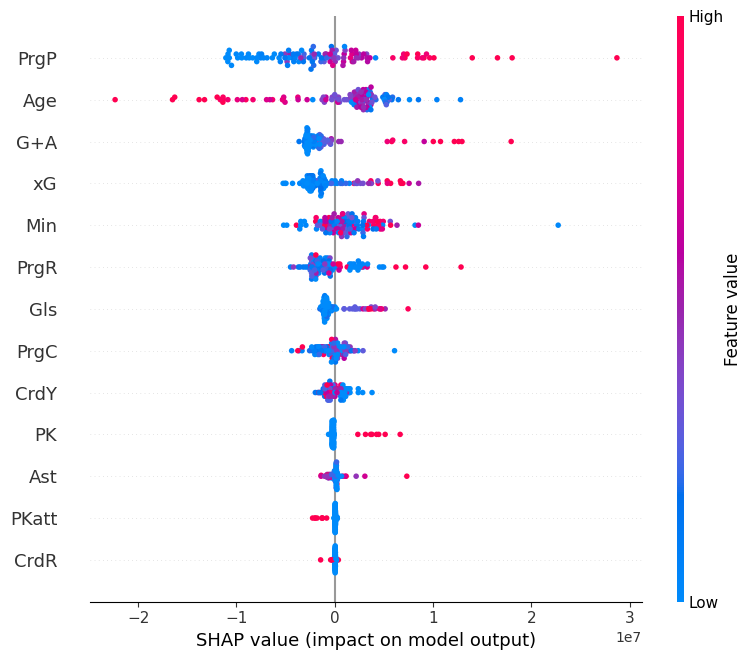

In [45]:
# SHAP 해석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [46]:
from sklearn.metrics import mean_absolute_error, r2_score

pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, pred):.2f}")
print(f"R²: {r2_score(y_test, pred):.2f}")

MAE: 9941927.00
R²: 0.35


In [47]:
import pandas as pd

# 입력값 
input_data = {
    'Age': 25,
    'Gls': 30,
    'Ast': 6,
    'G+A':36,
    'Min': 3330,
    'CrdY':3,
    'CrdR':0,
    'xG': 24,     
    'PrgC': 148,    
    'PrgP': 137,
    'PrgR': 320,  'PK':7,'PKatt':7
}


df_input = pd.DataFrame([input_data])


features = ['Age', 'Gls', 'Ast','G+A', 'Min', 'CrdY', 'CrdR','xG', 'PrgP','PrgC','PrgR','PK','PKatt'] 
X_input = df_input[features]

In [48]:
predicted_value = model.predict(X_input)
print(f"옛날 선수의 현재 시세 예측 몸값: {predicted_value[0]:.2f}")

옛날 선수의 현재 시세 예측 몸값: 124546408.00
